<a href="https://colab.research.google.com/github/Yoshibansal/Machine-learning/blob/main/Decision-Trees/Decision_Trees_for_Dating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [46]:
!wget "https://www.openml.org/data/get_csv/13153954/speeddating.arff" -O "speeddating.csv"

--2021-10-04 16:03:23--  https://www.openml.org/data/get_csv/13153954/speeddating.arff
Resolving www.openml.org (www.openml.org)... 131.155.11.11
Connecting to www.openml.org (www.openml.org)|131.155.11.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘speeddating.csv’

speeddating.csv         [    <=>             ]   4.76M  6.20MB/s    in 0.8s    

2021-10-04 16:03:58 (6.20 MB/s) - ‘speeddating.csv’ saved [4988096]



In [3]:
data = pd.read_csv("speeddating.csv", low_memory=False)
data

,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,importance_same_race,importance_same_religion,d_importance_same_race,d_importance_same_religion,field,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,d_pref_o_attractive,d_pref_o_sincere,d_pref_o_intelligence,d_pref_o_funny,d_pref_o_ambitious,d_pref_o_shared_interests,attractive_o,sinsere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,d_attractive_o,d_sinsere_o,d_intelligence_o,d_funny_o,d_ambitous_o,d_shared_interests_o,attractive_important,...,tv,theater,movies,concerts,music,shopping,yoga,d_sports,d_tvsports,d_exercise,d_dining,d_museums,d_art,d_hiking,d_gaming,d_clubbing,d_reading,d_tv,d_theater,d_movies,d_concerts,d_music,d_shopping,d_yoga,interests_correlate,d_interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,expected_num_matches,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match
0,0,1,female,21,27,6,[4-6],'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,2,4,[2-5],[2-5],Law,35,20,20,20,0,5,[21-100],[16-20],[16-20],[16-20],[0-15],[0-15],6,8,8,8,8,6,[6-8],[6-8],[6-8],[6-8],[6-8],[6-8],15,...,9,1,10,10,9,8,1,[9-10],[0-5],[6-8],[9-10],[0-5],[0-5],[0-5],[0-5],[0-5],[6-8],[9-10],[0-5],[9-10],[9-10],[9-10],[6-8],[0-5],0.14,[0-0.33],3,2,4,[0-4],[0-3],[3-5],7,6,[6-8],[5-6],0,1,0,0
1,0,1,female,21,22,1,[0-1],'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,2,4,[2-5],[2-5],Law,60,0,0,40,0,0,[21-100],[0-15],[0-15],[21-100],[0-15],[0-15],7,8,10,7,7,5,[6-8],[6-8],[9-10],[6-8],[6-8],[0-5],15,...,9,1,10,10,9,8,1,[9-10],[0-5],[6-8],[9-10],[0-5],[0-5],[0-5],[0-5],[0-5],[6-8],[9-10],[0-5],[9-10],[9-10],[9-10],[6-8],[0-5],0.54,[0.33-1],3,2,4,[0-4],[0-3],[3-5],7,5,[6-8],[5-6],1,1,0,0
2,1,1,female,21,22,1,[0-1],'Asian/Pacific Islander/Asian-American','Asian/Pacific Islander/Asian-American',1,2,4,[2-5],[2-5],Law,19,18,19,18,14,12,[16-20],[16-20],[16-20],[16-20],[0-15],[0-15],10,10,10,10,10,10,[9-10],[9-10],[9-10],[9-10],[9-10],[9-10],15,...,9,1,10,10,9,8,1,[9-10],[0-5],[6-8],[9-10],[0-5],[0-5],[0-5],[0-5],[0-5],[6-8],[9-10],[0-5],[9-10],[9-10],[9-10],[6-8],[0-5],0.16,[0-0.33],3,2,4,[0-4],[0-3],[3-5],7,?,[6-8],[0-4],1,1,1,1
3,0,1,female,21,23,2,[2-3],'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,2,4,[2-5],[2-5],Law,30,5,15,40,5,5,[21-100],[0-15],[0-15],[21-100],[0-15],[0-15],7,8,9,8,9,8,[6-8],[6-8],[9-10],[6-8],[9-10],[6-8],15,...,9,1,10,10,9,8,1,[9-10],[0-5],[6-8],[9-10],[0-5],[0-5],[0-5],[0-5],[0-5],[6-8],[9-10],[0-5],[9-10],[9-10],[9-10],[6-8],[0-5],0.61,[0.33-1],3,2,4,[0-4],[0-3],[3-5],7,6,[6-8],[5-6],0,1,1,1
4,0,1,female,21,24,3,[2-3],'Asian/Pacific Islander/Asian-American','Latino/Hispanic American',0,2,4,[2-5],[2-5],Law,30,10,20,10,10,20,[21-100],[0-15],[16-20],[0-15],[0-15],[16-20],8,7,9,6,9,7,[6-8],[6-8],[9-10],[6-8],[9-10],[6-8],15,...,9,1,10,10,9,8,1,[9-10],[0-5],[6-8],[9-10],[0-5],[0-5],[0-5],[0-5],[0-5],[6-8],[9-10],[0-5],[9-10],[9-10],[9-10],[6-8],[0-5],0.21,[0-0.33],3,2,4,[0-4],[0-3],[3-5],6,6,[6-8],[5-6],0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,1,21,male,25,26,1,[0-1],European/Caucasian-American,'Latino/Hispanic American',0,1,1,[0-1],[0-1],'Climate Dynamics',10,10,30,20,10,15,[0-15],[0-15],[21-100],[16-20],[0-15],[0-15],10,5,3,2,6,5,[9-10],[0-5],[0-5],[0-5],[6-8],[0-5],70,...,3,7,9,10,10,7,3,[6-8],[0-5],[0-5],[9-10],[9-10],[9-10],[6-8],[0-5],[9-10],[6-8],[0-5],[6-8],[9-10],[9-10],[9-10],[6-8],[0-5],0.64,[0.33-1],10,?,3,[7-10],[0-3],[3-5],2,5,[0-5],[5-6],0,0,1,0
8374,1,21,male,25,24,1,[0-1],Europea

Handling Missing Values

In [4]:
from sklearn.impute import SimpleImputer
se = SimpleImputer(missing_values="?", strategy="most_frequent")
data_imputed = se.fit_transform(data)
data_imp = pd.DataFrame(data_imputed, columns=data.columns)

In [5]:
data_imp = data_imp.drop("field", axis=1)

Conversion of Numerical Ranges to mean values

Function for conversion of ranges to average

In [6]:
def rangeToAvg(names, data):
  for name in names:
    vals = []
    ranges = data[name].values
    for i in ranges:
      if i[1] != "-":
        temp = (i[1:-1].split("-"))
        temp = [float(i) for i in temp]
      else:
        temp = (i[1:-1].split("-"))
        temp = temp[1:]
        temp[0] = -float(temp[0])
        temp[1] = float(temp[1])
      vals.append(np.mean(temp))
    data[name] = vals
  return data

Using regular expression to find column names of range values

In [7]:
import re
ind = 0
col_names = []
for i in data_imp.columns:
  x = re.findall("^d_", i)
  if len(x) > 0:
    col_names.append(data_imp.columns[ind])
  ind += 1
col_names = col_names[1:]

In [8]:
data_imp = rangeToAvg(col_names, data_imp)

In [9]:
#Onehot encoding
from sklearn.preprocessing import OneHotEncoder
arr_enc = ["Asian/Pacific Islander/Asian-American", "Black/African American", "Latino/Hispanic American", "European/Caucasian-American", "Other"]
enc = OneHotEncoder()
y = enc.fit_transform(data_imp[["race"]]).toarray()
y = pd.DataFrame(y, columns=arr_enc)
data_imp = pd.concat([y,data_imp], axis=1)

In [10]:
arr_enc = ["Asian/Pacific Islander/Asian-American", "Black/African American", "Latino/Hispanic American", "European/Caucasian-American", "Other"]
arr_enc = [i + "_o" for i in arr_enc]
enc = OneHotEncoder()
y = enc.fit_transform(data_imp[["race_o"]]).toarray()
y = pd.DataFrame(y, columns=arr_enc)
data_imp = pd.concat([y,data_imp], axis=1)

In [11]:
enc = OneHotEncoder()
y = enc.fit_transform(data_imp[["gender"]]).toarray()
y = pd.DataFrame(y, columns=["female", "male"])
data_imp = pd.concat([y,data_imp], axis=1)

In [12]:
data_imp = data_imp.drop_duplicates()

In [13]:
data_imp = data_imp.drop(["race", "race_o", "gender"], axis=1)
data_imp

,female,male,Asian/Pacific Islander/Asian-American_o,Black/African American_o,Latino/Hispanic American_o,European/Caucasian-American_o,Other_o,Asian/Pacific Islander/Asian-American,Black/African American,Latino/Hispanic American,European/Caucasian-American,Other,has_null,wave,age,age_o,d_age,d_d_age,samerace,importance_same_race,importance_same_religion,d_importance_same_race,d_importance_same_religion,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,d_pref_o_attractive,d_pref_o_sincere,d_pref_o_intelligence,d_pref_o_funny,d_pref_o_ambitious,d_pref_o_shared_interests,attractive_o,sinsere_o,intelligence_o,funny_o,ambitous_o,...,tv,theater,movies,concerts,music,shopping,yoga,d_sports,d_tvsports,d_exercise,d_dining,d_museums,d_art,d_hiking,d_gaming,d_clubbing,d_reading,d_tv,d_theater,d_movies,d_concerts,d_music,d_shopping,d_yoga,interests_correlate,d_interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,expected_num_matches,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,21,27,6,5.0,0,2,4,3.5,3.5,35,20,20,20,0,5,60.5,18.0,18.0,18.0,7.5,7.5,6,8,8,8,8,...,9,1,10,10,9,8,1,9.5,2.5,7.0,9.5,2.5,2.5,2.5,2.5,2.5,7.0,9.5,2.5,9.5,9.5,9.5,7.0,2.5,0.14,0.165,3,2,4,2.0,1.5,4.0,7,6,7.0,5.5,0,1,0,0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,21,22,1,0.5,0,2,4,3.5,3.5,60,0,0,40,0,0,60.5,7.5,7.5,60.5,7.5,7.5,7,8,10,7,7,...,9,1,10,10,9,8,1,9.5,2.5,7.0,9.5,2.5,2.5,2.5,2.5,2.5,7.0,9.5,2.5,9.5,9.5,9.5,7.0,2.5,0.54,0.665,3,2,4,2.0,1.5,4.0,7,5,7.0,5.5,1,1,0,0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,21,22,1,0.5,1,2,4,3.5,3.5,19,18,19,18,14,12,18.0,18.0,18.0,18.0,7.5,7.5,10,10,10,10,10,...,9,1,10,10,9,8,1,9.5,2.5,7.0,9.5,2.5,2.5,2.5,2.5,2.5,7.0,9.5,2.5,9.5,9.5,9.5,7.0,2.5,0.16,0.165,3,2,4,2.0,1.5,4.0,7,5,7.0,2.0,1,1,1,1
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,21,23,2,2.5,0,2,4,3.5,3.5,30,5,15,40,5,5,60.5,7.5,7.5,60.5,7.5,7.5,7,8,9,8,9,...,9,1,10,10,9,8,1,9.5,2.5,7.0,9.5,2.5,2.5,2.5,2.5,2.5,7.0,9.5,2.5,9.5,9.5,9.5,7.0,2.5,0.61,0.665,3,2,4,2.0,1.5,4.0,7,6,7.0,5.5,0,1,1,1
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,21,24,3,2.5,0,2,4,3.5,3.5,30,10,20,10,10,20,60.5,7.5,18.0,7.5,7.5,18.0,8,7,9,6,9,...,9,1,10,10,9,8,1,9.5,2.5,7.0,9.5,2.5,2.5,2.5,2.5,2.5,7.0,9.5,2.5,9.5,9.5,9.5,7.0,2.5,0.21,0.165,3,2,4,2.0,1.5,4.0,6,6,7.0,5.5,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,21,25,26,1,0.5,0,1,1,0.5,0.5,10,10,30,20,10,15,7.5,7.5,60.5,18.0,7.5,7.5,10,5,3,2,6,...,3,7,9,10,10,7,3,7.0,2.5,2.5,9.5,9.5,9.5,7.0,2.5,9.5,7.0,2.5,7.0,9.5,9.5,9.5,7.0,2.5,0.64,0.665,10,3,3,8.5,1.5,4.0,2,5,2.5,5.5,0,0,1,0
8374,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,21,25,24,1,0.5,0,1,1,0.5,0.5,50,20,10,5,10,5,60.5,18.0,7.5,7.5,7.5,7.5,6,3,7,3,7,...,3,7,9,10,10,7,3,7.0,2.5,2.5,9.5,9.5,9.5,7.0,2.5,9.5,7.0,2.5,7.0,9.5,9.5,9.5,7.0,2.5,0.71,0.665,10,3,3,8.5,1.5,4.0,4,4,2.5,2.0,0,0,0,0
8375,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,21,25,29,4,5.0,0,1,1,0.5,0.5,40,10,30,10,10,10,60.5,7.5,60.5,7.5,7.5,7.5,2,1,2,2,2,...,3,7,9,10,10,7,3,7.0,2.5,2.5,9.5,9.5,9.5,7.0,2.5,9.5,7.0,2.5,7.0,9.5,9.5,9.5,7.0,2.5,-0.46,-0.500,10,3,3,8.5,1.5,4.0,6,5,7.0,5.5,0,0,0,0
8376,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,21,25,22,3,2.5,0,1,1,0.5,0.5,10,25,25,10,10,20,7.5,60.5,60.5,7.5,7.5,18.0,5,7,5,5,3,...,3,7,9,10,10,7,3,7.0,2.5,2.5,9.5,9.5,9.5,7.0,2.5,9.5,7.0,2.5,7.0,9.5,9.5,9.5,7.0,2.5,0.62,0.665,10,3,3,8.5,1.5,4.0,5,5,2.5,5.5,0,0,1,0


In [14]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
data_exp1 = minmax.fit_transform(data_imp)
data_scaled = pd.DataFrame(data_exp1, columns=data_imp.columns)
data_scaled

,female,male,Asian/Pacific Islander/Asian-American_o,Black/African American_o,Latino/Hispanic American_o,European/Caucasian-American_o,Other_o,Asian/Pacific Islander/Asian-American,Black/African American,Latino/Hispanic American,European/Caucasian-American,Other,has_null,wave,age,age_o,d_age,d_d_age,samerace,importance_same_race,importance_same_religion,d_importance_same_race,d_importance_same_religion,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,d_pref_o_attractive,d_pref_o_sincere,d_pref_o_intelligence,d_pref_o_funny,d_pref_o_ambitious,d_pref_o_shared_interests,attractive_o,sinsere_o,intelligence_o,funny_o,ambitous_o,...,tv,theater,movies,concerts,music,shopping,yoga,d_sports,d_tvsports,d_exercise,d_dining,d_museums,d_art,d_hiking,d_gaming,d_clubbing,d_reading,d_tv,d_theater,d_movies,d_concerts,d_music,d_shopping,d_yoga,interests_correlate,d_interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,expected_num_matches,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081081,0.243243,0.162162,0.209302,0.0,0.2,0.333333,0.4,0.4,0.35,0.333333,0.40,0.40,0.000000,0.166667,1.000000,0.198113,0.198113,0.198113,0.0,0.000000,0.571429,0.8,0.8,0.727273,0.8,...,0.888889,0.1,1.0,1.0,0.888889,0.777778,0.1,1.000000,0.0,0.642857,1.0,0.0,0.0,0.000000,0.0,0.0,0.642857,1.0,0.000000,1.0,1.0,1.0,0.642857,0.0,0.557471,0.570815,0.222222,0.10,0.222222,0.0,0.0,0.285714,0.7,0.6,0.642857,0.538462,0.000,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081081,0.108108,0.027027,0.000000,0.0,0.2,0.333333,0.4,0.4,0.60,0.000000,0.00,0.80,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.666667,0.8,1.0,0.636364,0.7,...,0.888889,0.1,1.0,1.0,0.888889,0.777778,0.1,1.000000,0.0,0.642857,1.0,0.0,0.0,0.000000,0.0,0.0,0.642857,1.0,0.000000,1.0,1.0,1.0,0.642857,0.0,0.787356,1.000000,0.222222,0.10,0.222222,0.0,0.0,0.285714,0.7,0.5,0.642857,0.538462,0.125,1.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.081081,0.108108,0.027027,0.000000,1.0,0.2,0.333333,0.4,0.4,0.19,0.300000,0.38,0.36,0.264151,0.400000,0.198113,0.198113,0.198113,0.198113,0.0,0.000000,0.952381,1.0,1.0,0.909091,1.0,...,0.888889,0.1,1.0,1.0,0.888889,0.777778,0.1,1.000000,0.0,0.642857,1.0,0.0,0.0,0.000000,0.0,0.0,0.642857,1.0,0.000000,1.0,1.0,1.0,0.642857,0.0,0.568966,0.570815,0.222222,0.10,0.222222,0.0,0.0,0.285714,0.7,0.5,0.642857,0.000000,0.125,1.0,1.0,1.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081081,0.135135,0.054054,0.093023,0.0,0.2,0.333333,0.4,0.4,0.30,0.083333,0.30,0.80,0.094340,0.166667,1.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.666667,0.8,0.9,0.727273,0.9,...,0.888889,0.1,1.0,1.0,0.888889,0.777778,0.1,1.000000,0.0,0.642857,1.0,0.0,0.0,0.000000,0.0,0.0,0.642857,1.0,0.000000,1.0,1.0,1.0,0.642857,0.0,0.827586,1.000000,0.222222,0.10,0.222222,0.0,0.0,0.285714,0.7,0.6,0.642857,0.538462,0.000,1.0,1.0,1.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081081,0.162162,0.081081,0.093023,0.0,0.2,0.333333,0.4,0.4,0.30,0.166667,0.40,0.20,0.188679,0.666667,1.000000,0.000000,0.198113,0.000000,0.0,0.198113,0.761905,0.7,0.9,0.545455,0.9,...,0.888889,0.1,1.0,1.0,0.888889,0.777778,0.1,1.000000,0.0,0.642857,1.0,0.0,0.0,0.000000,0.0,0.0,0.642857,1.0,0.000000,1.0,1.0,1.0,0.642857,0.0,0.597701,0.570815,0.222222,0.10,0.222222,0.0,0.0,0.285714,0.6,0.6,0.642857,0.538462,0.000,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,

In [15]:
X = data_scaled.iloc[:, :-1].values
y = data_scaled.iloc[:, -1].values

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

Decision Tree Classifier

In [17]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(splitter="random",  max_features="auto", random_state=0, criterion="entropy", class_weight="balanced", max_depth=5)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=0, splitter='random')

In [18]:
print("Accuracy:", dtc.score(X_test, y_test) * 100, "%")

Accuracy: 98.80668257756562 %


In [24]:
y_pred = dtc.predict(X_test)

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1735
         1.0       0.96      0.97      0.97       360

    accuracy                           0.99      2095
   macro avg       0.98      0.98      0.98      2095
weighted avg       0.99      0.99      0.99      2095

[[1721   14]
 [  11  349]]


In [26]:
import seaborn as se

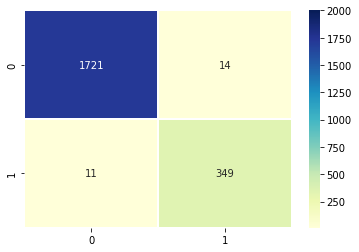

In [36]:
se.heatmap(confusion_matrix(y_test, y_pred), 
           annot=True, fmt="d", 
           linewidths=.5, 
           vmin=10, vmax=2000, 
           cmap="YlGnBu")

Decision Tree Classifier 2.0


In [37]:
dtc2 = DecisionTreeClassifier()
dtc2.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [38]:
print("Accuracy:", dtc2.score(X_test, y_test) * 100, "%")

Accuracy: 100.0 %


In [40]:
y_pred = dtc2.predict(X_test)

In [43]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1735
         1.0       1.00      1.00      1.00       360

    accuracy                           1.00      2095
   macro avg       1.00      1.00      1.00      2095
weighted avg       1.00      1.00      1.00      2095



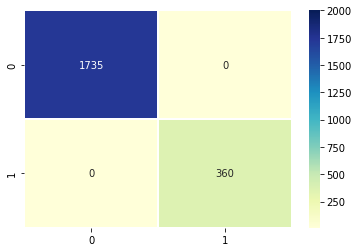

In [45]:
se.heatmap(confusion_matrix(y_test, y_pred), 
           annot=True, fmt="d", 
           linewidths=.5, 
           vmin=10, vmax=2000, 
           cmap="YlGnBu");